In [121]:
import util as u
import pandas as pd
import pyBigWig
import numpy as np
import seaborn as sns
import re
from liftover import get_lifter
from bisect import bisect_left
import matplotlib.pyplot as plt

data='/labs/mpsnyder/moqri/data/index/'

hg19tohg38='http://hgdownload.soe.ucsc.edu/goldenPath/hg19/liftOver/hg19ToHg38.over.chain.gz'

In [2]:
tss=pd.read_csv('files/tss38.csv',index_col=0)
print(tss.shape)
ezh=tss[tss.v>1]
ezh.shape

(31335, 8)


(929, 8)

In [53]:
df=pd.read_csv(data+'wg/cpgs.csv',index_col=0)
df.columns=['h9']+list(df.columns)[1:]
df.shape

(3153046, 5)

In [54]:
cells=['ips','nb','md','ct','sy','so']
for cell in cells:
    print(cell,end=',')
    dt=pd.read_csv(data+'wg/'+cell+'.csv',index_col=0)
    dt.columns=[cell]
    df=df.merge(dt,how='left',left_index=True,right_index=True)
len(df)/(10**6)    

ips,nb,md,ct,sy,so,

3.153046

In [55]:
df=df.dropna()
df.shape

(3145200, 11)

<ipython-input-56-2e5b596afbb3>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(['g','tss','d','dq'],1).mean().plot(kind='bar')


<AxesSubplot:>

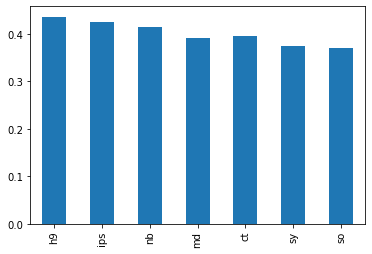

In [56]:
df.drop(['g','tss','d','dq'],1).mean().plot(kind='bar')

(1539125, 17)


<AxesSubplot:>

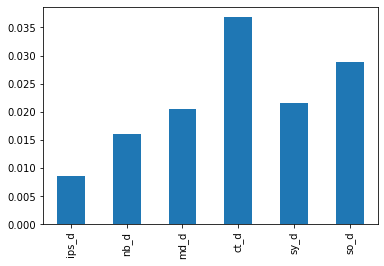

In [57]:
dl=df[df.h9<.2]
for cell in cells:
    dl[cell+'_d']=dl[cell]-dl.h9
print(dl.shape)
dl[[cell+'_d' for cell in cells]].mean().plot(kind='bar')

(177664, 14)


<ipython-input-58-739da1047d00>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dle=dl[dl.tss.isin(ezh.g)].drop(['g','tss','d'],1)


<AxesSubplot:>

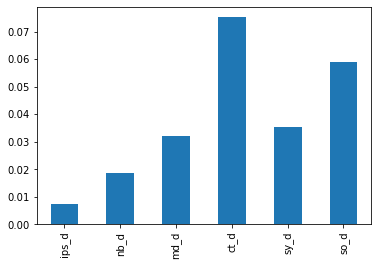

In [58]:
dle=dl[dl.tss.isin(ezh.g)].drop(['g','tss','d'],1)
print(dle.shape)
dle[[cell+'_d' for cell in cells]].mean().plot(kind='bar')

In [59]:
flank=pd.read_table(data+'wg/flank.fasta',header=None)
flank=flank[~flank[0].str.contains('chr')]
df['flank']=flank[0].values
flank.shape

(3145200, 1)

In [60]:
dh=df[df.h9>.6]
print(dh.shape)

(1429786, 12)


In [61]:
for cell in cells:
    dh[cell+'_d']=dh.h9-dh[cell]

<AxesSubplot:>

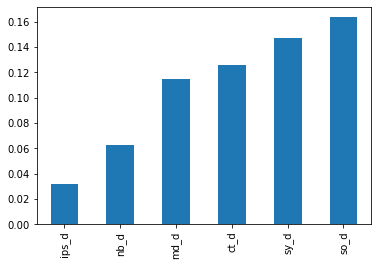

In [62]:
dh[[cell+'_d' for cell in cells]].mean().plot(kind='bar')

(165968, 15)


<ipython-input-63-6d6f016d4866>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dho=dh[dh.flank.str[0].isin(['A','T'])&dh.flank.str[3].isin(['A','T'])].drop(['g','tss','d'],1)


<AxesSubplot:>

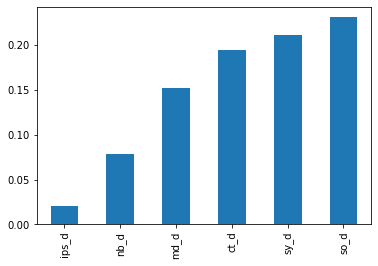

In [63]:
dho=dh[dh.flank.str[0].isin(['A','T'])&dh.flank.str[3].isin(['A','T'])].drop(['g','tss','d'],1)
print(dho.shape)
dho[[cell+'_d' for cell in cells]].mean().plot(kind='bar')

(3145200, 12)

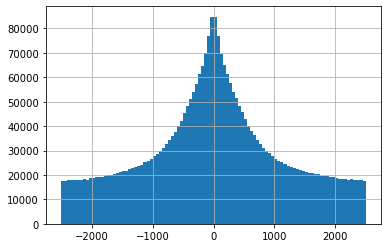

In [64]:
df.d.hist(bins=100)
df.shape

In [65]:
tss=df.tss.unique()
len(tss)

31172

In [69]:
df['tss']=df.g.apply(lambda y:u.take_closest(tss, y))
df['d']=df.g-df.tss
df['dq']=pd.qcut(df.d,11)

In [134]:
samples=[
    {'cells':['h9','ips','nb','md','ct'],
     'labels':['hESC','iPSC','Newborn T Cell','Middle-age T Cell','Centenerian T Cell'],
     'pal':["#c44e52","#FB9101","#55a868","#0000FF","#180e17"]
    },
    {'cells':['h9','ips','sy','so'],
      'labels':['hESC','iPSC','Young Epidermis','Old Epidermis'],
     'pal':["#c44e52","#55a868","#0000FF","#180e17"]
    }
]

<ipython-input-141-6ae7e8e0180c>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dle=dl[dl.tss.isin(ezh.g)].drop(['g','tss','d'],1)


(177664, 9)


<ipython-input-141-6ae7e8e0180c>:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dho=dh[dh.flank.str[0].isin(['A','T'])&dh.flank.str[3].isin(['A','T'])].drop(['g','tss','d'],1)
<ipython-input-141-6ae7e8e0180c>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dle=dl[dl.tss.isin(ezh.g)].drop(['g','tss','d'],1)


(177664, 9)


<ipython-input-141-6ae7e8e0180c>:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dho=dh[dh.flank.str[0].isin(['A','T'])&dh.flank.str[3].isin(['A','T'])].drop(['g','tss','d'],1)


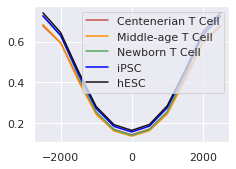

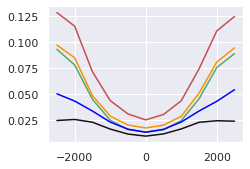

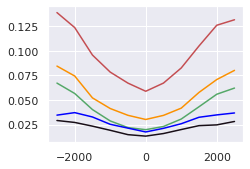

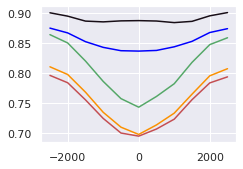

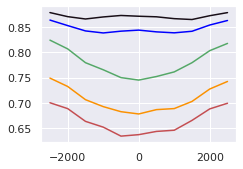

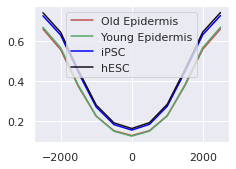

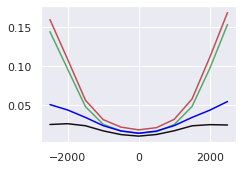

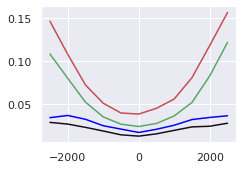

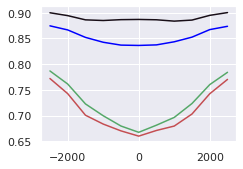

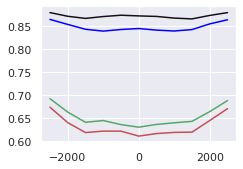

In [141]:
for sample in samples:   
    cell=sample['cells']
    label=sample['labels']
    pal=sample['pal']
    sns.set(rc={'figure.figsize':(3.5,2.5)})
    pl=df[cell+['dq']].groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    plt.figure()
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal))
    plt.figure()
    dl=df[df.h9<.2]
    pl=dl.groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal),legend=False)
    plt.figure()
    dle=dl[dl.tss.isin(ezh.g)].drop(['g','tss','d'],1)
    print(dle.shape)
    pl=dle.groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal),legend=False)
    plt.figure()
    dh=df[df.h9>.6]
    pl=dh.groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal),legend=False)
    plt.figure()
    dho=dh[dh.flank.str[0].isin(['A','T'])&dh.flank.str[3].isin(['A','T'])].drop(['g','tss','d'],1)
    pl=dho.groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal),legend=False)

In [20]:
man='https://zhouserver.research.chop.edu/InfiniumAnnotation/20180909/HM450/HM450.hg38.manifest.tsv.gz'
man=pd.read_table(man)
man=man[~man.CpG_chrm.isna()][man.CpG_chrm!='chrX'][man.CpG_chrm!='chrY'][man.CpG_chrm!='chrM']
man['CpG_chrm']=man.CpG_chrm.str[3:].astype(float)
man.index=man.CpG_chrm.astype(int).astype(str)+'_'+man.CpG_beg.astype(int).astype(str)

wb450='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE40nnn/GSE40279/matrix/GSE40279_series_matrix.txt.gz'
!wget -q -nc {wb450} -O {datam}\wb450.gz
blood=pd.read_csv(datam+'/wb450.gz',sep='\t',index_col=0,skiprows=69, nrows=10**6)
print(blood.shape)
b_ages=pd.read_csv(datam+'/wb450.gz',sep='\t',skiprows=33,nrows=0,index_col=0).columns.values
b_ages=[float(age.strip('age: ').split('y')[0]) for age in b_ages]

liver450='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48325/matrix/GSE48325_series_matrix.txt.gz'
!wget -q -nc {liver450} -O {datam}\liver450.gz
liver=pd.read_csv(liver450, index_col=0,sep='\t', skiprows=60,nrows=10**6)
liver=liver.drop('!series_matrix_table_end')
print(liver.shape)
l_ages=pd.read_csv(liver450, index_col=0,sep='\t', skiprows=27,nrows=9).iloc[8].str.strip('age: ').astype(float)

sc_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31848/matrix/GSE31848_series_matrix.txt.gz'
meta=pd.read_table(sc_,skiprows=52,nrows=1,index_col=0)
meta=meta.T
sc=pd.read_table(sc_,skiprows=37+55,index_col=0)

<ipython-input-20-df94d23ec110>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  man=man[~man.CpG_chrm.isna()][man.CpG_chrm!='chrX'][man.CpG_chrm!='chrY'][man.CpG_chrm!='chrM']


(473035, 656)
(485577, 85)


<ipython-input-21-5fbc4d980710>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  b=blood.T.drop('!series_matrix_table_end',1)


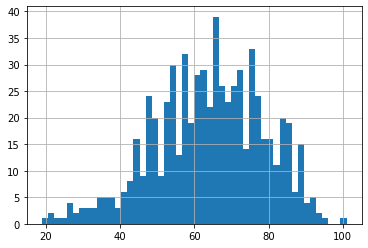

In [21]:
b=blood.T.drop('!series_matrix_table_end',1)
b['age']=b_ages
b.age.hist(bins=50)
b['age']=pd.cut(b.age,[20,30,40,50,60,70,80,90,100])
b=b.groupby('age').mean()

In [27]:
def arr(df):
    manh=man.loc[df.index.intersection(man.index)]
    print(manh.shape)
    ll=manh[['probeID']]
    ll=ll[ll.probeID.isin(b.columns)]
    ll['dq']=df.loc[ll.index].dq
    print(ll.shape)
    bs=b[ll.probeID].T
    bs['dq']=ll.dq.values
    pl=bs.groupby('dq').mean()
    pl.index=list(range(-2500,2501,500))
    pl.columns=pl.columns.rename('Liver Age')
    pl.columns=['20s Years','30s Years','40s Years','50s Years','60s Years','70s Years','80s Years','90s Years']
    scl=sc.loc[ll.probeID]
    scl['dq']=ll.dq.values
    sc1=scl[list(meta[meta.index.str.contains('ES__')]['!Sample_geo_accession'].values)+['dq']].groupby('dq').mean().mean(1)
    sc2=scl[list(meta[meta.index.str.contains('iPS__')]['!Sample_geo_accession'].values)+['dq']].groupby('dq').mean().mean(1)
    scg=pd.concat([sc1,sc2],1)
    scg.index=pl.index
    scg.columns=['hESC','iPSC']
    pls=pd.concat([scg,pl],1)
    ax=sns.lineplot(data=pls,dashes=False,hue_order=['90s Years','80s Years','70s Years','60s Years','50s Years','40s Years','30s Years','20s Years','iPSC','hESC'],
                    palette = sns.color_palette("RdYlGn", 8)+["#0000FF","#180e17"])

(123993, 57)
(123842, 2)


<ipython-input-27-0da555e7adb0>:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  scg=pd.concat([sc1,sc2],1)
<ipython-input-27-0da555e7adb0>:21: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pls=pd.concat([scg,pl],1)


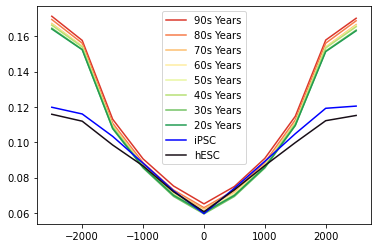

In [28]:
arr(dl)

(11707, 57)
(11699, 2)


<ipython-input-27-0da555e7adb0>:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  scg=pd.concat([sc1,sc2],1)
<ipython-input-27-0da555e7adb0>:21: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pls=pd.concat([scg,pl],1)


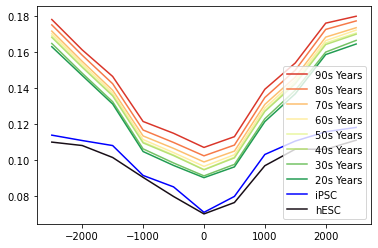

In [84]:
arr(dle)

(61253, 57)
(61161, 2)


<ipython-input-27-0da555e7adb0>:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  scg=pd.concat([sc1,sc2],1)
<ipython-input-27-0da555e7adb0>:21: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pls=pd.concat([scg,pl],1)


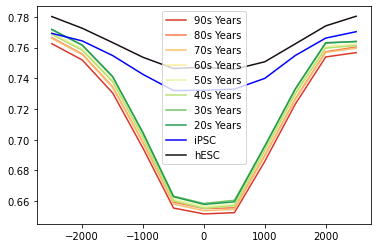

In [29]:
arr(dh)

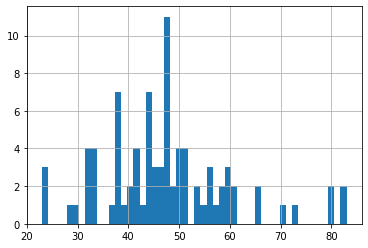

In [59]:
l=liver.T
l['age']=l_ages
l.age.hist(bins=50)
l['age']=pd.cut(l.age,[20,30,40,50,60])
l=l.groupby('age').mean()

In [61]:
ll=manh[['probeID']]
ll['dq']=df.loc[ll.index].dq
print(ll.shape)
l=l[ll.probeID].T
l['dq']=ll.dq.values
pl=l.groupby('dq').mean()
pl.index=list(range(-2500,2501,500))

(9106, 2)


In [62]:
pl.columns=pl.columns.rename('Liver Age')
pl.columns=['20-30 Years','30-40 Years','40-50 Years','50+ Years']
scl=sc.loc[ll.probeID]
scl['dq']=ll.dq.values
sc1=scl[list(meta[meta.index.str.contains('ES__')]['!Sample_geo_accession'].values)+['dq']].groupby('dq').mean().mean(1)
sc2=scl[list(meta[meta.index.str.contains('iPS__')]['!Sample_geo_accession'].values)+['dq']].groupby('dq').mean().mean(1)
scg=pd.concat([sc1,sc2],1)
scg.index=pl.index
scg.columns=['hESC','iPSC']
pls=pd.concat([scg,pl],1)

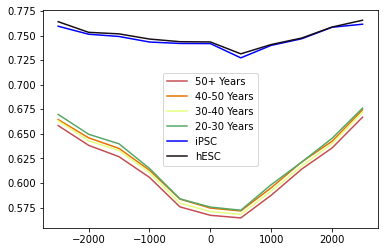

In [70]:
ax=sns.lineplot(data=pls,dashes=False,hue_order=['50+ Years','40-50 Years','30-40 Years','20-30 Years','iPSC','hESC'],
                palette = sns.color_palette(["#c44e52","#E57300","#E4FF7F","#55a868","#0000FF","#180e17"]))

In [66]:
mane_='https://webdata.illumina.com/downloads/productfiles/methylationEPIC/infinium-methylationepic-v-1-0-b5-manifest-file-csv.zip'
mane=pd.read_csv(mane_,skiprows=7,index_col=0)

/home/moqri/anaconda3/envs/stem/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2,4,42,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [37]:
era_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE142nnn/GSE142439/matrix/GSE142439_series_matrix.txt.gz'

In [42]:
era=pd.read_table(era_,skiprows=71,index_col=0)

In [47]:
era.shape

(866092, 16)

In [48]:
mane.shape

(866554, 52)

In [76]:
mane = mane[mane['Start_hg38'].notna()]
mane.shape

(865880, 51)

In [88]:
mane['g']=mane.CHR_hg38.str[3:]+'_'+mane.Start_hg38.astype(int).astype(str)

In [90]:
man_dle=mane[mane.g.isin(dle.index)]

In [94]:
mane.index=mane.g

In [112]:
    manh=mane.loc[dho.index.intersection(mane.index)]
    print(manh.shape)
    ll=manh[['Name']]
    ll=ll[ll['Name'].isin(b.columns)]
    ll['dq']=df.loc[ll.index].dq
    print(ll.shape)
    bs=era.T[ll['Name']].T
    bs['dq']=ll.dq.values
    pl=bs.groupby('dq').mean()
    pl.index=list(range(-2500,2501,500))
    scl=sc.loc[ll['Name']]
    scl['dq']=ll.dq.values
    sc1=scl[list(meta[meta.index.str.contains('ES__')]['!Sample_geo_accession'].values)+['dq']].groupby('dq').mean().mean(1)
    sc2=scl[list(meta[meta.index.str.contains('iPS__')]['!Sample_geo_accession'].values)+['dq']].groupby('dq').mean().mean(1)
    scg=pd.concat([sc1,sc2],1)
    scg.index=pl.index
    scg.columns=['hESC','iPSC']
    pls=pd.concat([scg,pl],1)


(20541, 52)
(8570, 2)


<ipython-input-112-b1b1d2a7a5d5>:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  scg=pd.concat([sc1,sc2],1)
<ipython-input-112-b1b1d2a7a5d5>:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pls=pd.concat([scg,pl],1)


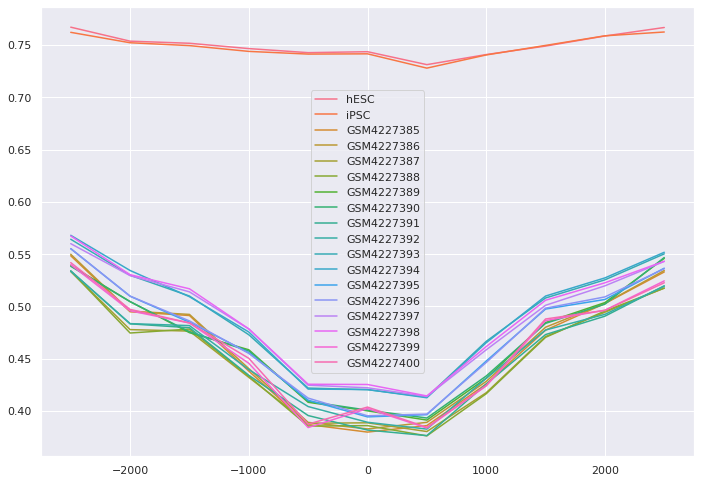

In [113]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax=sns.lineplot(data=pls,dashes=False)

In [114]:
pls.mean()

hESC          0.750100
iPSC          0.748098
GSM4227385    0.460378
GSM4227386    0.462250
GSM4227387    0.452492
GSM4227388    0.451584
GSM4227389    0.467466
GSM4227390    0.467746
GSM4227391    0.453979
GSM4227392    0.457711
GSM4227393    0.489318
GSM4227394    0.490474
GSM4227395    0.472259
GSM4227396    0.472778
GSM4227397    0.487694
GSM4227398    0.490124
GSM4227399    0.460601
GSM4227400    0.461835
dtype: float64